# Cusp-capturing PINN - Example 5

* level set augmentation: $\phi_a = |\phi|$

### Import packages

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import functools
from pyDOE import lhs
from scipy.stats.distributions import norm as spnorm

from functorch import make_functional, vmap, grad, jacrev, hessian

from collections import namedtuple, OrderedDict
import datetime
import time
from IPython.display import clear_output 

import warnings
warnings.filterwarnings('ignore')

### Empty cache and check devices 

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


### Pre-setup

In [3]:
# unit sphere domain S^d
dims  = 6
dims0 = dims - 1
Rad   = .6
# radii of the sphere
rk = .5
rsq = rk * rk
# input_size
input_size = dims + 1
# \beta^+, \beta^-, and \eta
btao = 1.
btai = 1.
bta_jmp = btao - btai
bta_avg = 0.5*( btao + btai )
# Network size
n_input0 = dims
n_input  = n_input0 + 1
n_hidden = 40
n_output = 1
n_depth  = 1 # only used in deep NN
# tolerence for LM
tol_main    = 10**(-10)
tol_machine = 10**(-15)
mu_max      = 10**8
mu_ini      = 10**8
mu_div      = 1.3
mu_mul      = 2.
# iteration counts and check
tr_iter_max    = 3000                      # max. iteration
ts_input_new   = 500                       # renew testing points 
ls_check       = 500
ls_check0      = ls_check - 1
# number of training points and testing points
c_addpt = 1.
N_trd = 500
N_trb = int( 6*(N_trd)**(5./6.) )
N_trg = N_trb
N_tsd_final = 100*N_trd
N_tsb_final = 100*N_trb
N_tsg_final = 100*N_trg
# create names for storages
fname = 'test'
char_id = 'a'

### Exact solution, level set function, and right-hand-side

In [4]:
def levfun(opt, x):
    nr = np.size(x,0)
    qo = np.zeros((nr,1))
    qo[:,0] = np.sum(x*x, axis=1)/rsq - 1.0
    if opt == 0:
        q = np.zeros_like(qo)
        for i in range(len(qo)):
            if qo[i] >= 0.:
                q[i] = qo[i]
            else:
                q[i] = - qo[i]
    else:
        nc = np.size(x,1);
        q  = np.zeros( (nr,nc+3) )
        q[:,0:1]  = qo
        q[:,1:-2] = 2*x/rsq
        q[:,-1]   = 2*nc/rsq
        for i in range(nr):
            if qo[i] >= 0.:
                q[i,:] = q[i,:]
            else:
                q[i,:] = - q[i,:]
        q[:,-2] = np.sum( q[:,1:-2]*q[:,1:-2] , axis=1 )
    return qo, q


def lvnorvec(x):
    qnor   = x/rsq
    dqsqrt = np.sqrt( np.sum(qnor*qnor,axis=1) ).reshape((len(x[:,0]),1))
    qnor   = qnor/dqsqrt  
    return qnor


# exact solution of example 01
def exact_u(x, z):
    eu = np.sum( np.sin(x[:,0:-1]) , axis=1 ).reshape( (len(z),1) )
    dd = rsq - np.sum( x*x , axis=1 )
    for i in range(len(z)):
        if z[i] >= 0.:
            eu[i] += np.exp( dd[i] )
        else:
            eu[i] += 1. + 2*np.sin( dd[i] )
    return eu


def exact_b(x, z):
    eb = np.zeros_like(z)
    for i in range(len(z)):
        if z[i] >= 0.:
            eb[i] = btao
        else:
            eb[i] = btai
    return eb


# normal derivative jump of level set function
def jump_lvdn(x):
    qdn_jmp = (4/rsq)* np.sqrt( np.sum( x*x , axis=1 ) ).reshape((len(x[:,0]),1))
    return qdn_jmp


# normal derivative jump condition along interface: [\beta\partial_n u]=0 
def jump_btadun(x):
    dun = rk*(4*btai-2*btao) + (bta_jmp/rk)*np.sum( np.cos(x[:,0:-1])*x[:,0:-1]  , axis=1 )
    dun = dun.reshape((len(x[:,0]),1))
    return dun


# source
def lapu(x, z):
    ef = - np.sum( np.sin(x[:,0:-1]) , axis=1 ).reshape( (len(z),1) )
    dd = np.sum( x*x , axis=1 ).reshape( (len(z),1) )
    ep = rsq - dd
    cs = np.cos( ep )
    ss = np.sin( ep )
    ep = np.exp( ep )
    for i in range(len(z)):
        if z[i] >= 0.:
            ef[i] += ( 4*dd[i] - 12. )*ep[i]
        else:
            ef[i] += - 8*dd[i]*ss[i] - 24*cs[i]            
    return ef

### Define networks: Shallow and Deep

In [5]:
class NeuralNet_Shallow(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    
    def __init__(self, in_dim , h_dim , out_dim):
        super(NeuralNet_Shallow, self).__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1 =nn.Tanh()
        #self.act1 =nn.ReLU()
        
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out

In [6]:
class NeuralNet_Deep(torch.nn.Module):
    
    ### in_dim: dimension of input; h_dim: number of neurons; out_dim: dimension of output
    ### depth: depth of the network
    def __init__(self, in_dim , h_dim , out_dim , depth ):
        super(NeuralNet_Deep, self).__init__()
        self.depth = depth - 1
        self.list  = nn.ModuleList()
        self.ln1   = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        #self.act1  = nn.Tanh()
        
        for i in range(self.depth):
            self.list.append( nn.Linear( h_dim , h_dim ) )
        
        self.lnd = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        for i in range(self.depth):
            out = self.list[i](out)
            out = self.act1(out)
        out = self.lnd(out)
        return out

### Essential namedtuples in the model

In [7]:
DataInput = namedtuple( "DataInput" , [ "Xd" , "Fd" , "Xb" , "Fb" , "Xg" , "Fg" , "NL" , "NL_sqrt"] )
LM_Setup  = namedtuple( "LM_Setup" , [ 'p_vec_o' , 'dp_o' , 'L_o' , 'J_o' , 'mu0' , 'criterion' ] )

### Data generator

In [8]:
def generate_data(iopt, Nd, Nb, Ng):
    
    # Xd: interior points 
    r_d = lhs(1, samples=Nd)
    r_d = r_d**(1./dims)
    Xd = spnorm( loc=0 , scale=1 ).ppf( lhs(dims,samples=Nd) )
    Xd = Rad*Xd/np.expand_dims( np.linalg.norm(Xd,axis=1) , axis=1 )
    Xd = ( r_d*Xd ).reshape( ( Nd , dims ) )
    qo, q = levfun(1, Xd)
    Fd = np.hstack( ( q , lapu(Xd, qo) ) )
    Xd = np.hstack( ( Xd , q[:,0:1] ) )    
    
    # Xb: boundary points
    Xb = lhs( dims , samples=Nb )
    Xb = spnorm( loc=0 , scale=1 ).ppf(Xb)
    Xb = Rad*Xb/np.expand_dims( np.linalg.norm(Xb,axis=1) , axis=1 )
    Xb = Xb.reshape( ( Nb , dims ) )
    qo, q = levfun(0, Xb)
    Fb = exact_u(Xb, qo)
    Xb = np.hstack( ( Xb , q ) )

    # Xg: points on the interface
    Xg = lhs(dims, samples=Ng)
    Xg = spnorm( loc=0 , scale=1 ).ppf(Xg)
    Xg = rk*Xg/np.expand_dims( np.linalg.norm(Xg,axis=1) , axis=1 )
    Xg = Xg.reshape( ( Ng , dims ) )
    qo = np.zeros( (len(Xg[:,0]),1) )
    # normal vector along the interface
    Xnor_gm = lvnorvec(Xg)
    # normal derivative jump condition for level function
    Qdn_gm  = jump_lvdn(Xg)
    # normal derivative jump condition for u
    Udn_gm  = jump_btadun(Xg)     
    # combine and torch tensor
    Fg = np.hstack( ( Xnor_gm , Qdn_gm , Udn_gm ) )
    Xg = np.hstack( ( Xg , qo ) )
   
    # torch tensor and requires_grad
    Xd = torch.tensor(Xd, requires_grad=True).double().to(device)
    Xb = torch.tensor(Xb, requires_grad=True).double().to(device)
    Xg = torch.tensor(Xg, requires_grad=True).double().to(device)
    Fd = torch.tensor(Fd).double().to(device)
    Fb = torch.tensor(Fb).double().to(device)
    Fg = torch.tensor(Fg).double().to(device)
    
    NL      = [ Nd+Nb+Ng , Nd , Nb , Ng ]
    NL_sqrt = np.sqrt(NL)
    
    if ( iopt == 1 ):
        print(f'No. of training points in the bulk domain is {Nd}')
        print(f'No. of training points at the outer boundary is {Nb}')
        print(f'No. of training points at the interface is {Ng}')
        print(f'No. of overall training points is {Nd+Nb+Ng}')
        
    
    return Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt 

### Components of loss

In [9]:
# compute the interior loss
def func_lossd(func_params, pts, fd):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    
    d1u = jacrev(f)(pts, func_params)
    d2u = jacrev(jacrev(f))(pts, func_params)
    
    uq = d1u[6]
    u11 = d2u[0][0]
    u22 = d2u[1][1]
    u33 = d2u[2][2]
    u44 = d2u[3][3]
    u55 = d2u[4][4]
    u66 = d2u[5][5]
    uqq = d2u[6][6]
    u1q = d2u[0][6] 
    u2q = d2u[1][6]
    u3q = d2u[2][6] 
    u4q = d2u[3][6]
    u5q = d2u[4][6]
    u6q = d2u[5][6]
    lossd = u11 + u22 + u33 + u44 + u55 + u66 + 2.*( u1q*fd[1:2] + u2q*fd[2:3] + u3q*fd[3:4] + \
            u4q*fd[4:5] + u5q*fd[5:6] + u6q*fd[6:7] ) + uqq*fd[7:8] + uq*fd[8:9] - fd[9:10]
    return lossd


# compute the boundary loss 
def func_lossb(func_params, pts, fb):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # function value at the boundary (Dirichlet boundary condition)
    lossb = f(pts, func_params) - fb
    return lossb


# compute the interior loss
def func_lossg(func_params, pts, fg):
    def f(x, func_params):
        fx = func_model(func_params, x)
        return fx.squeeze(0).squeeze(0)
    # derivatives of u wrt inputs
    d1u = jacrev(f)(pts, func_params)
    ug0 = d1u[0]
    ug1 = d1u[1]
    ug2 = d1u[2]
    ug3 = d1u[3]
    ug4 = d1u[4]
    ug5 = d1u[5]
    ugq = d1u[6]
    lossg = bta_jmp*( ug0*fg[0:1] + ug1*fg[1:2] + ug2*fg[2:3] + ug3*fg[3:4] +  \
                      ug4*fg[4:5] + ug5*fg[5:6] ) + bta_avg*ugq*fg[6:7] - fg[7:8]
    return lossg

### Levenberg-Marquardt (LM) optimizer

In [10]:
# parameters counter
def count_parameters(func_params):
    return sum(p.numel() for p in func_params if p.requires_grad)

In [11]:
# get the model's parameter
def get_p_vec(func_params):
    p_vec = []
    cnt = 0
    for p in func_params:
        p_vec = p.contiguous().view(-1) if cnt == 0 else torch.cat([p_vec, p.contiguous().view(-1)])
        cnt = 1 
    return p_vec

In [12]:
# Initialization of LM method
def generate_initial_LM(func_params, Xd_len, Xb_len, Xg_len):
    
    # data_length
    data_length = Xd_len + Xb_len + Xg_len
    
    # p_vector
    with torch.no_grad():
        p_vec_old = get_p_vec(func_params).double().to(device)
    
    # dp
    dp_old = torch.zeros( [ count_parameters(func_params) , 1 ] ).double().to(device)

    # Loss
    L_old = torch.zeros( [ data_length , 1 ] ).double().to(device)
    
    # Jacobian
    J_old = torch.zeros( [ data_length , count_parameters(func_params) ] ).double().to(device)
    
    return p_vec_old, dp_old, L_old, J_old

In [13]:
def train_PINNs_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg):
    
    # assign tuple elements of LM_set_up
    p_vec_o, dp_o, L_o, J_o, mu, criterion = LM_setup
    I_pvec = torch.eye(len(p_vec_o)).to(device)
    
    # assign tuple elements of data_input 
    [Xd, Fd, Xb, Fb, Xg, Fg, NL, NL_sqrt] = tr_input
    
    # iteration counts and check
    Comput_old = True
    step       = 0
    
    # try-except statement to avoid jam in the code
    try:
        while (lossval[-1]>tol_main) and (step<=tr_iter_max):
            
            torch.cuda.empty_cache()
            
            ############################################################
            # LM_optimizer
            if ( Comput_old == True ):   # need to compute loss_old and J_old
                
                ### computation of loss
                Ld = vmap((func_lossd), (None, 0, 0))(func_params, Xd, Fd).flatten().detach()
                Lb = vmap((func_lossb), (None, 0, 0))(func_params, Xb, Fb).flatten().detach()
                Lg = vmap((func_lossg), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
                L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
                L  = L.reshape(NL[0],1).detach()
                lsd_sum = torch.sum(Ld*Ld)/NL[1]
                lsb_sum = torch.sum(Lb*Lb)/NL[2]
                lsg_sum = torch.sum(Lg*Lg)/NL[3]
                loss_dbg_old = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
                        
            loss_old     = lossval[-1]
            loss_dbg_old = lossval_dbg[-1]
    
            ### compute the gradinet of loss function for each point
            with torch.no_grad():
                p_vec = get_p_vec(func_params).detach() # get p_vec for p_vec_old if neccessary 
        
            if criterion:
                per_sample_grads = vmap(jacrev(func_lossd), (None, 0, 0))(func_params, Xd, Fd)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
                    cnt = 1

                per_sample_grads = vmap(jacrev(func_lossb), (None, 0, 0))(func_params, Xb, Fb)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_b = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_b,g.reshape(len(g),-1)])
                    cnt = 1
        
                per_sample_grads = vmap(jacrev(func_lossg), (None, 0, 0))(func_params, Xg, Fg)
                cnt = 0
                for g in per_sample_grads: 
                    g = g.detach()
                    J_g = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_g,g.reshape(len(g),-1)])
                    cnt = 1
            
                J = torch.cat( ( J_d/NL_sqrt[1] , J_b/NL_sqrt[2] , J_g/NL_sqrt[3] ) ).detach()
                
                ### info. normal equation of J
                J_product = J.t()@J
                rhs       = - J.t()@L
        
                    
            with torch.no_grad():
                ### solve the linear system
                dp  = torch.linalg.solve( J_product + mu*I_pvec , rhs )
                cnt = 0
                for p in func_params:
                    mm   = torch.Tensor([p.shape]).tolist()[0]
                    num  = int( functools.reduce( lambda x,y : x*y, mm, 1 ) )
                    p   += dp[cnt:cnt+num].reshape(p.shape)
                    cnt += num
            
            ### Compute loss_new    
            Ld = vmap((func_lossd), (None, 0, 0))(func_params, Xd, Fd).flatten().detach()
            Lb = vmap((func_lossb), (None, 0, 0))(func_params, Xb, Fb).flatten().detach()
            Lg = vmap((func_lossg), (None, 0, 0))(func_params, Xg, Fg).flatten().detach()
            L  = torch.cat( ( Ld/NL_sqrt[1] , Lb/NL_sqrt[2] , Lg/NL_sqrt[3] ) )
            L  = L.reshape( NL[0] , 1 ).detach()
            loss_new = torch.sum(L*L).item()
            lsd_sum = torch.sum(Ld*Ld)/NL[1]
            lsb_sum = torch.sum(Lb*Lb)/NL[2]
            lsg_sum = torch.sum(Lg*Lg)/NL[3]
            loss_dbg_new = [lsd_sum.item(), lsb_sum.item(), lsg_sum.item()]
    
                
            # strategy to update mu
            if ( step > 0 ):
                
                with torch.no_grad():
             
                    # accept update 
                    if loss_new < loss_old:
                        p_vec_old  = p_vec.detach()
                        dp_old     = dp
                        L_old      = L
                        J_old      = J
                        mu         = max( mu/mu_div , tol_machine )
                        criterion  = True #False
                        Comput_old = False
                        lossval.append(loss_new)
                        lossval_dbg.append(loss_dbg_new)
                    
                    else:
                        cosine = nn.functional.cosine_similarity(dp, dp_old, dim=0, eps=1e-15)
                        cosine_check = (1.-cosine)*loss_new > min(lossval) # loss_old
                        if cosine_check: # give up the direction
                            cnt=0
                            for p in func_params:
                                mm   = torch.Tensor([p.shape]).tolist()[0]
                                num  = int( functools.reduce(lambda x,y: x*y, mm, 1) )
                                p   -= dp[cnt:cnt+num].reshape(p.shape)
                                cnt += num
                            mu = min( mu_mul*mu , mu_max )
                            criterion  = False
                            Comput_old = False
                        else: # accept 
                            p_vec_old = p_vec.detach()
                            dp_old    = dp 
                            L_old     = L
                            J_old     = J
                            mu        = max( mu/mu_div , tol_machine )       
                            criterion  = True
                            Comput_old = False
                        lossval.append(loss_old)
                        lossval_dbg.append(loss_dbg_old)
            
            else:   # for old info. 
       
                with torch.no_grad():
              
                    p_vec_old  = p_vec.detach()
                    dp_old     = dp
                    L_old      = L
                    J_old      = J
                    mu         = max( mu/mu_div , tol_machine )
                    criterion  = True
                    Comput_old = False
                    lossval.append(loss_new)
                    lossval_dbg.append(loss_dbg_new)
            
           
            if step % ls_check == ls_check0:
                print("Step %s: " % (step) )
                print(f" training loss: {lossval[-1]:.4e}")
            
            step += 1
                  
        print("Step %s: " % (step-1) )
        print(f" training loss: {lossval[-1]:.4e}")
        print('finished')
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        relerr_loss = lossval[-1]
        return lossval, lossval_dbg, relerr_loss
    
    except KeyboardInterrupt:
        print('Interrupt')
        print('steps = ', step)
        lossval     = lossval[1:]
        lossval_dbg = lossval_dbg[1:]
        relerr_loss = lossval[-1]
        return lossval, lossval_dbg, relerr_loss

In [14]:
# storages for errors, time instants, and IRK stages
relerr_loss = []
for char in char_id:
    
    torch.cuda.empty_cache()
    
    # NN structure
    if n_depth == 1:   # Shallow NN
        model = NeuralNet_Shallow( n_input , n_hidden , n_output ).double().to(device)
    else:   # Deep NN
        model = NeuralNet_Deep( n_input , n_hidden , n_output , n_depth ).double().to(device)

    # use Pytorch and functorch
    func_model, func_params = make_functional(model)
    
    # generate training data
    Xd_tr, Fd_tr, Xb_tr, Fb_tr, Xg_tr, Fg_tr, NL_tr, NL_sqrt_tr = generate_data(1, N_trd, N_trb, N_trg)
    tr_input = DataInput(Xd=Xd_tr, Fd=Fd_tr, Xb=Xb_tr, Fb=Fb_tr, Xg=Xg_tr, Fg=Fg_tr, NL=NL_tr, NL_sqrt=NL_sqrt_tr)
    
    # initialization of LM
    p_vec_old, dp_old, L_old, J_old = generate_initial_LM(func_params, NL_tr[1], NL_tr[2], NL_tr[3])
    print(f"No. of trainable parameters = {len(p_vec_old)}")
        
    # LM_setup
    mu = 10**(8)
    criterion = True
    LM_setup = LM_Setup( p_vec_o=p_vec_old , dp_o=dp_old , L_o=L_old , J_o=J_old , mu0=mu , criterion=criterion )

    # allocate loss
    lossval         = []
    lossval_dbg     = []
    lossval.append(1.)
    lossval_dbg.append([1.,1.,1.])

    # train the model by LM optimizer
    lossval, lossval_dbg, relerr_loss_char = train_PINNs_LM(func_params, LM_setup, tr_input, lossval, lossval_dbg)
    relerr_loss.append(relerr_loss_char)

No. of training points in the bulk domain is 500
No. of training points at the outer boundary is 1064
No. of training points at the interface is 1064
No. of overall training points is 2628
No. of trainable parameters = 360
Step 499: 
 training loss: 6.1177e-08
Step 999: 
 training loss: 7.6182e-10
Step 1499: 
 training loss: 7.6182e-10
Step 1999: 
 training loss: 2.5419e-10
Step 2499: 
 training loss: 1.4325e-10
Step 2999: 
 training loss: 1.4130e-10
Step 3000: 
 training loss: 1.4130e-10
finished


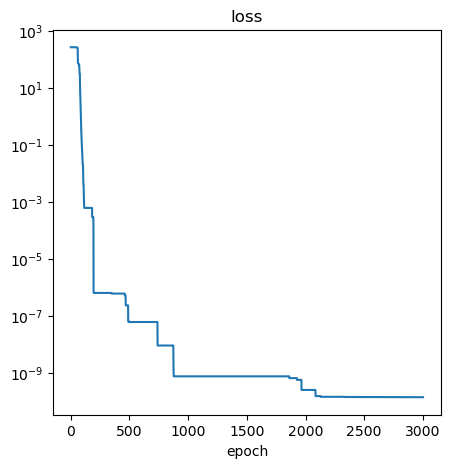

In [15]:
# plot evolution of loss
N_loss = len(lossval)
lossval        = np.array(lossval).reshape(N_loss,1)
epochcol = np.linspace(1, N_loss, N_loss).reshape(N_loss,1)

plt.figure(figsize = (5,5))

plt.semilogy(epochcol, lossval)
plt.title('loss')
plt.xlabel('epoch')
plt.show()

### Testing data

In [16]:
# No. of testing points
print(f'No. of testing points: ')
print(f'    N_tsd = {N_tsd_final}')
print(f'    N_tsb = {N_tsb_final}')
print(f'    N_tsg = {N_tsg_final}')
print(f'    Overall: {N_tsd_final + N_tsb_final + N_tsg_final}')

##### generate interior testing points and calculate error
# X_tsb: boundary points
X_tsb = lhs( dims , samples=N_tsb_final )
X_tsb = spnorm( loc=0 , scale=1 ).ppf(X_tsb)
X_tsb = Rad*X_tsb/np.expand_dims( np.linalg.norm(X_tsb,axis=1) , axis=1 )
X_tsb = X_tsb.reshape( ( N_tsb_final , dims ) )
qo, q = levfun(0, X_tsb)
ref_u_tsb = exact_u(X_tsb, qo)
X_tsb = np.hstack( ( X_tsb , q ) )
print(f'No. of testing points at the outer boundary is {N_tsb_final}')

# X_tsd: interior points 
r_tsd = lhs(1, samples=N_tsd_final)
r_tsd = r_tsd**(1./dims)
X_tsd = spnorm( loc=0 , scale=1 ).ppf( lhs(dims,samples=N_tsd_final) )
X_tsd = Rad*X_tsd/np.expand_dims( np.linalg.norm(X_tsd,axis=1) , axis=1 )
X_tsd = r_tsd*X_tsd
X_tsd = X_tsd.reshape( (N_tsd_final,dims) )
qo, q = levfun(0, X_tsd)
ref_u_tsd = exact_u(X_tsd, qo)
X_tsd = np.hstack( ( X_tsd , q ) )

print(f'No. of testing points in the bulk domain is {N_tsd_final}')

##### generate interfacial testing points and calculate error
## X_gma: points on the interface
X_tsg = lhs(dims, samples=N_tsg_final)
X_tsg = spnorm( loc=0 , scale=1 ).ppf(X_tsg)
X_tsg = rk*X_tsg/np.expand_dims( np.linalg.norm(X_tsg,axis=1) , axis=1 )
X_tsg = X_tsg.reshape( (N_tsg_final,dims) )
qo = np.zeros( (len(X_tsg[:,0]),1) )
ref_u_tsg = exact_u(X_tsg, qo)
X_tsg = np.hstack( ( X_tsg , qo ) )

print(f'No. of testing points at the interface is {N_tsg_final}')

## normal derivative jump condition for level function
qdn_tsg = jump_lvdn(X_tsg)
## normal derivative jump condition for u
udn_tsg = jump_btadun(X_tsg) 

X_tst = torch.tensor( np.vstack( ( X_tsd , X_tsb , X_tsg ) ) ).double().to(device)
ref_u_tst = np.vstack( ( ref_u_tsd , ref_u_tsb , ref_u_tsg ) )
ref_u_tst_infnorm = np.linalg.norm( ref_u_tst , np.inf )
ref_u_tst_2norm   = np.linalg.norm( ref_u_tst , 2 )


No. of testing points: 
    N_tsd = 50000
    N_tsb = 106400
    N_tsg = 106400
    Overall: 262800
No. of testing points at the outer boundary is 106400
No. of testing points in the bulk domain is 50000
No. of testing points at the interface is 106400


In [17]:
pred_u = func_model(func_params, X_tst).cpu().detach().numpy().flatten()
abserr = np.abs( pred_u - ref_u_tst.flatten() )
err_inf = np.linalg.norm(abserr, np.inf)
err_L2  = np.linalg.norm(abserr, 2)
relerr_inf = err_inf / ref_u_tst_infnorm
print(f"L_inf err.    : {err_inf:.4e}")
print(f"L_inf relerr. : {relerr_inf:.4e}")
relerr_L2  = err_L2 / ref_u_tst_2norm
print(f"L_2 err.    : {err_L2:.4e}")
print(f"L_2 relerr. : {relerr_L2:.4e}")

L_inf err.    : 1.4001e-05
L_inf relerr. : 6.3280e-06
L_2 err.    : 8.9873e-04
L_2 relerr. : 1.6262e-06
